# Econometrics & Causal Inference



## Google Causal Impact

* Define pre and post periods (pre should be longer than post)
* Retrieve data
* Check whether the variables are correlated in the pre-period
* Remove non-correlated data
* Use causal impact

In [1]:
%cd /content/drive/MyDrive/Business Analyst course/Econometrics and Causal Inference/Google Causal Impact

/content/drive/MyDrive/Business Analyst course/Econometrics and Causal Inference/Google Causal Impact


In [ ]:
!pip install yfinance
!pip install tfcausalimpact

In [3]:
import yfinance as yf
from causalimpact import CausalImpact
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as st
import math as m
import statsmodels.stats.api as sm
import numpy as np


### The problem we are studying

**We are studying the bitcoin price to measure the impact of Paypal accepting bitcoin on bitcoin's price.**

In [4]:
#Dates
training_start =  "2020-09-01" 
training_end =    "2020-10-19"
treatment_start = "2020-10-20"
treatment_end =   "2020-10-23"
end_stock =       "2020-10-24"

### Loading financial data

In [5]:
y = ["BTC-USD"]
y = yf.download(tickers=y,
                start = training_start,
                end = end_stock,
                interval = '1d')
y = y['Adj Close'].rename("y")
y[:1]

[*********************100%***********************]  1 of 1 completed


Date
2020-09-01    11970.478516
Name: y, dtype: float64

###Assumptions

* **Parallel Trends Assumption** : the treatment and control groups are assumed to have the same evolution for the KPI
* **Confounding Policy Change** : There is only one policy that differentiate the treatment from the control groups.

We can strenghthen the assumptions by:
* using more control groups
* using a longer training period 
* keeping the post-treatment period to the bare minimum.

In [6]:
stocks = ["ZAL.DE", "SQ", "CRSP", "TRMB", "JD", "DE", "KTOS", "GOOG"]
X = yf.download(tickers=stocks,
                start = training_start,
                end = end_stock,
                interval = '1d')
X.head()

[*********************100%***********************]  8 of 8 completed


Adj Close                                               \
                 CRSP          DE       GOOG         JD       KTOS   
Date                                                                 
2020-09-01  93.419998  211.338715  83.035500  80.459969  19.700001   
2020-09-02  93.930000  210.775650  86.414001  81.162254  19.910000   
2020-09-03  85.690002  204.659454  82.092003  77.094872  19.520000   
2020-09-04  82.019997  205.173996  79.552002  78.031250  19.260000   
2020-09-07        NaN         NaN        NaN        NaN        NaN   

                                                  Close              ...  \
                    SQ       TRMB     ZAL.DE       CRSP          DE  ...   
Date                                                                 ...   
2020-09-01  166.660004  53.410000  77.000000  93.419998  217.690002  ...   
2020-09-02  162.880005  54.310001  77.000000  93.930000  217.110001  ...   
2020-09-03  152.860001  50.900002  75.080002  85.690002  210.809998  ...   
2020-09-04  146.389999  49.959999  71.739998  82.019997  211.339996  ...   
2020-09-07         NaN        NaN  74.000000        NaN         NaN  ...   

                 Open                Volume                         \
                 TRMB     ZAL.DE       CRSP         DE        GOOG   
Date                                                                 
2020-09-01  52.669998  74.959999   779500.0  1873400.0  36506000.0   
2020-09-02  53.779999  77.500000   532000.0  1983000.0  50224000.0   
2020-09-03  54.130001  77.260002  1278900.0  1975200.0  62156000.0   
2020-09-04  51.040001  74.800003  1570300.0  1662300.0  52172000.0   
2020-09-07        NaN  72.239998        NaN        NaN         NaN   

                                                                  
                    JD       KTOS          SQ       TRMB  ZAL.DE  
Date                                                              
2020-09-01  11431400.0   587600.0  12306400.0   542300.0  790198  
2020-09-02  13860900.0   612800.0  11214800.0   728800.0  496554  
2020-09-03  19254000.0   847100.0  16421200.0  1220300.0  736259  
2020-09-04  21500900.0  1060000.0  17995200.0   914700.0  662250  
2020-09-07         NaN        NaN         NaN        NaN  362062  

[5 rows x 48 columns]

In [7]:
# we need to get rid of NaNs, and format our table
X = X.iloc[:,:len(stocks)]
X.head(1)

Adj Close                                                         \
                 CRSP          DE     GOOG         JD       KTOS          SQ   
Date                                                                           
2020-09-01  93.419998  211.338715  83.0355  80.459969  19.700001  166.660004   

                          
             TRMB ZAL.DE  
Date                      
2020-09-01  53.41   77.0

In [8]:
X.columns

MultiIndex([('Adj Close',   'CRSP'),
            ('Adj Close',     'DE'),
            ('Adj Close',   'GOOG'),
            ('Adj Close',     'JD'),
            ('Adj Close',   'KTOS'),
            ('Adj Close',     'SQ'),
            ('Adj Close',   'TRMB'),
            ('Adj Close', 'ZAL.DE')],
           )

In [9]:
X.columns = X.columns.droplevel()
X.head(1)

,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,
2020-09-01,93.419998,211.338715,83.0355,80.459969,19.700001,166.660004,53.41,77.0


In [11]:
X.index = X.index.tz_localize(None)
X.index

DatetimeIndex(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02',
               '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23'],
              dtype='datetime64[ns]', name='Date', freq='B')

In [ ]:
#Combine everything
df = pd.concat([y, X], axis = 1 ).dropna()
df

###Data Analysis

In [13]:
df_training = df[df.index <= training_end]
df_training.tail(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-10-19,11742.037109,107.720001,232.015839,76.730499,78.626236,20.639999,186.960007,51.970001,85.0


#### Stationarity 

Two series could be correlated just because they are both growing or both going down. 
What we are interested are the patterns that are stationary.

Differencing -> Stationary Data (with constant mean, variance, covariance)

In [14]:
from statsmodels.tsa.stattools import adfuller
test = adfuller(x = df_training.y)[1]
print(test)
if test < 0.05:
  print("The time serie is stationary")
else:
  print("The time serie is NOT stationary")

0.0987470320882271
The time serie is NOT stationary


In [15]:
#differencing : substract or divide
differencing = df_training.pct_change().dropna()
differencing.head(2)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-02,-0.046485,0.005459,-0.002664,0.040687,0.008728,0.010660,-0.022681,0.016851,0.000000
2020-09-03,-0.102395,-0.087725,-0.029018,-0.050015,-0.050114,-0.019588,-0.061518,-0.062788,-0.024935


In [16]:
test = adfuller(x = differencing.y)[1]
print(test)
if test < 0.05:
  print("The time serie is stationary")
else:
  print("The time serie is NOT stationary")

3.8054323617260893e-07
The time serie is stationary


<Axes: >

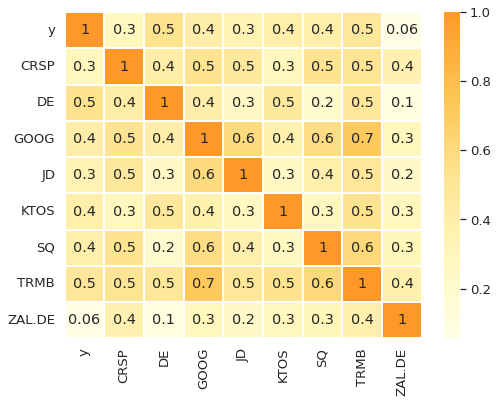

In [17]:
#Correlation Matrix : finding a similar control group
plt.figure(figsize=(8,6))
sns.set(font_scale = 1.2)
sns.heatmap(differencing.corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'YlOrBr',
            center = True,
            linewidth = 2)

In [18]:
# removing the ZAL.DE that is not correlated at all
df_final = df.drop(columns = ["ZAL.DE"])
df_final.head(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB
Date,,,,,,,,
2020-09-01,11970.478516,93.419998,211.338715,83.0355,80.459969,19.700001,166.660004,53.41


###Causal Impact

In [19]:
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


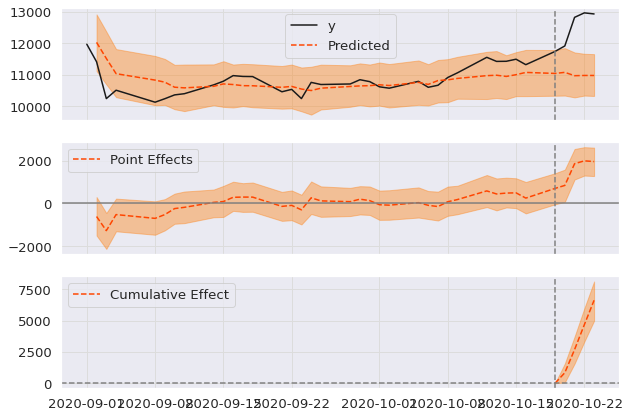

In [20]:
impact = CausalImpact(data = df_final, 
                      pre_period = pre_period, 
                      post_period = post_period)
impact.plot()

In [21]:
# Impact greater in the beginning
# Impact gradually increases
# Impact stabilizes a few days after

In [22]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12659.36           50637.45
Prediction (s.d.)         11002.36 (198.0)   44009.46 (792.0)
95% CI                    [10596.56, 11372.71][42386.25, 45490.84]

Absolute effect (s.d.)    1657.0 (198.0)     6628.0 (792.0)
95% CI                    [1286.65, 2062.8]  [5146.61, 8251.21]

Relative effect (s.d.)    15.06% (1.8%)      15.06% (1.8%)
95% CI                    [11.69%, 18.75%]   [11.69%, 18.75%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [23]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 12659.36. By contrast, in the absence of an
intervention, we would have expected an average response of 11002.36.
The 95% interval of this counterfactual prediction is [10596.56, 11372.71].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1657.0 with a 95% interval of
[1286.65, 2062.8]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 50637.45.
By contrast, had the intervention not taken place, we would have expected
a sum of 44009.46. The 95% interval of this prediction is [42386.25, 45490.84].


The above results are given in terms of absolute numbers. In relative
te

## Matching

* There is no comparable control group, so we have to create one.
* Beware of (self-)selection bias
* Create a counter group with similar characteristics to the treatment group

In [24]:
%cd /content/drive/MyDrive/Business Analyst course/Econometrics and Causal Inference/Matching

/content/drive/MyDrive/Business Analyst course/Econometrics and Causal Inference/Matching


In [58]:
df = pd.read_csv("school.csv")

In [59]:
df.head(2)

,childid,catholic,race,number_places_lived,mom_age,dad_age,dad_education,mom_education,mom_score,dad_score,income,poverty,food_stamps,score_standardized
0,0001002C,0,"WHITE, NON-HISPANIC",1,47,45,DOCTORATE OR PROFESSIONAL DEGREE,SOME COLLEGE,53.50,77.5,62500.5,0,0,0.981753
1,0001004C,0,"WHITE, NON-HISPANIC",1,41,48,BACHELOR'S DEGREE,GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,34.95,53.5,45000.5,0,0,0.594378


In [60]:
!pip install CausalInference

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
from causalinference import CausalModel

In [62]:
df = df.iloc[:,1:] # remove first column (childid)

In [63]:
df.head()

,catholic,race,number_places_lived,mom_age,dad_age,dad_education,mom_education,mom_score,dad_score,income,poverty,food_stamps,score_standardized
0,0,"WHITE, NON-HISPANIC",1,47,45,DOCTORATE OR PROFESSIONAL DEGREE,SOME COLLEGE,53.50,77.5,62500.5,0,0,0.981753
1,0,"WHITE, NON-HISPANIC",1,41,48,BACHELOR'S DEGREE,GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,34.95,53.5,45000.5,0,0,0.594378
2,0,"WHITE, NON-HISPANIC",1,43,55,"MASTER'S DEGREE (MA, MS)",GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,63.43,53.5,62500.5,0,0,0.490611
3,1,"WHITE, NON-HISPANIC",1,38,39,BACHELOR'S DEGREE,GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,53.50,53.5,87500.5,0,0,1.451278
4,0,"WHITE, NON-HISPANIC",1,47,57,DOCTORATE OR PROFESSIONAL DEGREE,"MASTER'S DEGREE (MA, MS)",61.56,77.5,150000.5,0,0,2.595699


### Unconfoundedness

* The variables (confounders) are enough to describe the people or entities
* The characteristics affect the likelihood of someone being part of the treatment 
* The combination of the confounders and the treatment leads to the outcome.

### Data Analysis

In [64]:
#compare the averages of both groups
df.groupby('catholic').mean()

,number_places_lived,mom_age,dad_age,mom_score,dad_score,income,poverty,food_stamps,score_standardized
catholic,,,,,,,,,
0,1.106246,37.794621,40.134919,43.909495,42.590520,65393.928540,0.101578,0.045566,0.163128
1,1.073118,39.775269,42.007527,47.620871,45.908269,86180.625269,0.016129,0.006452,0.219685


In [65]:
import scipy.stats as ss

In [66]:
#t-test : Are the differences statistically significant ?
# H0 = means are statistically similar

continuous = ['number_places_lived', 'mom_age', 'dad_age', 'mom_score', 'dad_score', 'income']

stat = {}
p = {}

for x in continuous:
  group1 = df.where(df.catholic == 0).dropna()[x]
  group2 = df.where(df.catholic == 1).dropna()[x]
  stat[x], p[x] = ss.ttest_ind(group1, group2)

ttests = pd.DataFrame.from_dict(p, orient = 'Index')
ttests.columns = ['pvalue']
print(ttests)

                           pvalue
number_places_lived  7.072609e-03
mom_age              1.359492e-22
dad_age              3.344265e-16
mom_score            2.280116e-19
dad_score            5.489722e-18
income               5.943636e-41


In [67]:
# p < 0.05 => rejecting H0 => means are statistically different

In [68]:
# chi-square : H0 = there are no differences between the classes in the population
categorical = ['poverty', 'food_stamps']

p = {}

for x in categorical:
  tab = pd.crosstab(index = df[x], columns = df.catholic)
  chi2, p[x], dof, expected = ss.chi2_contingency(tab)

chisquare = pd.DataFrame.from_dict(p, orient = 'Index')
chisquare.columns = ['pvalue']
print(chisquare)

                   pvalue
poverty      6.511355e-17
food_stamps  3.294153e-08


In [69]:
# p < 0.05 => rejecting H0 => classes are statistically different

### Data Preparation

* Let's simplify our model, remove insignificant options / data
* not using pd.get_dummies() because that would add too many columns

In [70]:
df.race.value_counts()

WHITE, NON-HISPANIC                        3654
HISPANIC, RACE NOT SPECIFIED                408
HISPANIC, RACE SPECIFIED                    387
BLACK OR AFRICAN AMERICAN, NON-HISPANIC     357
ASIAN                                       342
MORE THAN ONE RACE, NON HISPANIC            123
NATIVE HAWAIIAN, OTHER PACIFIC ISLANDER      93
AMERICAN INDIAN OR ALASKA NATIVE             62
NOT ASCERTAINED                               3
Name: race, dtype: int64

In [76]:
df['race_white'] = np.where(df.race == 'WHITE, NON-HISPANIC', 1 , 0)
df['race_hispanic'] = np.where(((df.race == 'HISPANIC, RACE NOT SPECIFIED') | (df.race == 'HISPANIC, RACE SPECIFIED')), 1 , 0)
df['race_black'] = np.where(df.race == 'BLACK OR AFRICAN AMERICAN, NON-HISPANIC', 1 , 0)
df['race_asian'] = np.where(df.race == 'ASIAN', 1 , 0)
# no need to add "other", it will be when the 4 others are 0

In [77]:
df.head(2)

,catholic,race,number_places_lived,mom_age,dad_age,dad_education,mom_education,mom_score,dad_score,income,poverty,food_stamps,score_standardized,race_white,race_hispanic,race_black,race_asian
0,0,"WHITE, NON-HISPANIC",1,47,45,DOCTORATE OR PROFESSIONAL DEGREE,SOME COLLEGE,53.50,77.5,62500.5,0,0,0.981753,1,0,0,0
1,0,"WHITE, NON-HISPANIC",1,41,48,BACHELOR'S DEGREE,GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,34.95,53.5,45000.5,0,0,0.594378,1,0,0,0


In [78]:
df.mom_education.value_counts()

SOME COLLEGE                              1721
HIGH SCHOOL DIPLOMA/EQUIVALENT            1306
BACHELOR'S DEGREE                         1085
MASTER'S DEGREE (MA, MS)                   387
VOC/TECH PROGRAM                           294
9TH - 12TH GRADE                           222
GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE     170
8TH GRADE OR BELOW                         134
DOCTORATE OR PROFESSIONAL DEGREE           110
Name: mom_education, dtype: int64

In [81]:
df['dad_higher_education'] = np.where((df.dad_education == "BACHELOR'S DEGREE") | 
                                      (df.dad_education == "MASTER'S DEGREE (MA, MS)")  | 
                                      (df.dad_education == "DOCTORATE OR PROFESSIONAL DEGREE"), 
                                      1, 0)
df['mom_higher_education'] = np.where((df.mom_education == "BACHELOR'S DEGREE") | 
                                      (df.mom_education == "MASTER'S DEGREE (MA, MS)")  | 
                                      (df.mom_education == "DOCTORATE OR PROFESSIONAL DEGREE"), 
                                      1, 0)

In [82]:
df.head(2)

,catholic,race,number_places_lived,mom_age,dad_age,dad_education,mom_education,mom_score,dad_score,income,poverty,food_stamps,score_standardized,race_white,race_hispanic,race_black,race_asian,dad_higher_education,mom_higher_education
0,0,"WHITE, NON-HISPANIC",1,47,45,DOCTORATE OR PROFESSIONAL DEGREE,SOME COLLEGE,53.50,77.5,62500.5,0,0,0.981753,1,0,0,0,1,0
1,0,"WHITE, NON-HISPANIC",1,41,48,BACHELOR'S DEGREE,GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,34.95,53.5,45000.5,0,0,0.594378,1,0,0,0,1,0


In [85]:
# clean the df

df = df.drop(columns = ["race", "dad_education", "mom_education"])
df.head(1)

,catholic,number_places_lived,mom_age,dad_age,mom_score,dad_score,income,poverty,food_stamps,score_standardized,race_white,race_hispanic,race_black,race_asian,dad_higher_education,mom_higher_education
0,0,1,47,45,53.5,77.5,62500.5,0,0,0.981753,1,0,0,0,1,0


In [87]:
# isolate confounders, treat, y
treat = df.catholic.values
y = df.score_standardized.values
confounders = df.drop(columns=["catholic","score_standardized"]).values

### Common Support Region

In [92]:
#Logistic Regression
import statsmodels.api as sm
confounders_csr = sm.add_constant(confounders)
csr_model = sm.Logit(treat, confounders_csr).fit()

Optimization terminated successfully.
         Current function value: 0.430983
         Iterations 8


In [94]:
#Predictions
probabilities = csr_model.predict(confounders_csr)
probabilities

array([0.26041384, 0.17273291, 0.24596599, ..., 0.23182116, 0.12192314,
       0.1825144 ])

In [99]:
# plotting the common support region

df_prob = np.vstack([treat,probabilities])
df_prob = np.transpose(df_prob)

non_treated = df_prob[:,0] == 0
non_treated = df_prob[non_treated, 1]
treated = df_prob[:,0] == 1
treated = df_prob[treated, 1]

<Axes: ylabel='Density'>

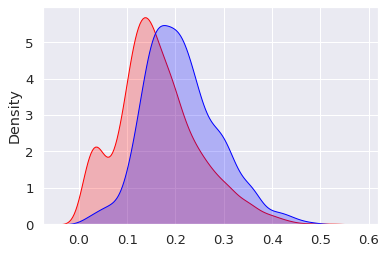

In [101]:
sns.kdeplot(non_treated, fill = True, color = 'red')
sns.kdeplot(treated, fill = True, color = 'blue')

###Matching Model

In [102]:
model = CausalModel(y, treat, confounders)
model.est_via_matching(bias_adj = True)
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.133      0.065     -2.044      0.041     -0.260     -0.005
           ATC     -0.126      0.073     -1.737      0.082     -0.268      0.016
           ATT     -0.167      0.060     -2.786      0.005     -0.284     -0.049



/usr/local/lib/python3.9/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [103]:
# ATE : Average Treatement Effect = potential effect
# ATC : ATE on the Control Group
# ATT : ATE on the treated = de facto effect

In [104]:
# In our case we are looking for ATE : potential effect of being catholic

In [105]:
# P>|z| 0.041 < 0.05 => statistically significant
# Est. -0.133 (95% CI [-0.260 - -0.005]) => catholic perform worse

### Robustness checks

* Repeat experiment with different subsamples
* Remove one confounder

In [106]:
# repeated samples

In [107]:
# isolate the coefficient
model.estimates['matching']['ate']


-0.13297192873362434

In [ ]:
ate = {}
i = 0

while i < 1000:
  # sampling
  sample = df.sample(1000) # we have 5429

  # isolation of treat, y and confounders
  treat = sample.catholic.values
  y = sample.score_standardized.values
  confounders = sample.drop(columns=["catholic","score_standardized"]).values

  # matching model
  model = CausalModel(y, treat, confounders)
  model.est_via_matching(bias_adj = True)

  # store the result
  ate[i] = model.estimates['matching']['ate']

  print(i)
  i += 1



Axes(0.125,0.125;0.775x0.755)
-0.1290178785481435


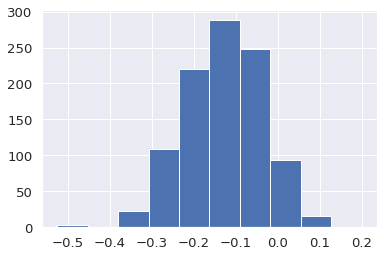

In [109]:
ate = pd.Series(ate)
print(ate.hist())
print(ate.mean())

In [110]:
# removing one confounder should not change the result significantly

treat = df.catholic.values
y = df.score_standardized.values
confounders = df.drop(columns=["catholic","score_standardized", "number_places_lived"]).values

model = CausalModel(y, treat, confounders)
model.est_via_matching(bias_adj = True)
print(model.estimates)

/usr/local/lib/python3.9/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.137      0.066     -2.069      0.039     -0.266     -0.007
           ATC     -0.136      0.074     -1.842      0.065     -0.281      0.009
           ATT     -0.141      0.060     -2.348      0.019     -0.259     -0.023

